# Traffic sign classification



# Transfer Learning

In [1]:
import os # work with directory
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
img_size = 224
from keras.utils import to_categorical

In [2]:
print(os.listdir("Training-1"))
print(os.listdir("Testing-1"))

['00000', '00001', '00002', '00003', '00004', '00005']
['00000', '00001', '00002', '00003', '00004', '00005']


load_dataset method which will be used for loading the traning dataset as well as testing dataset.

In [3]:
def load_dataset(file_name):
    if file_name == "Training-1":
        directory = "Training-1"
    elif file_name =="Testing-1":
        directory = "Testing-1"
        
    list_images =[]
    list_labels=[]
    
    count = 0
        
    for sub_dir in tqdm(os.listdir(directory)):

        
        if sub_dir == 'Readme.txt':
            pass
        
        else:
            inner_directory = os.path.join(directory,sub_dir)
            for image_file in os.listdir(inner_directory):
                
                if image_file.endswith(".ppm"):
                    
                    img = cv2.imread(os.path.join(inner_directory,image_file))
                    img = cv2.resize(img,(img_size,img_size))
                    
                    list_images.append(img)
                    
                    list_labels.append(count)
            count +=1   
            
    list_images = np.array(list_images).reshape(-1,img_size,img_size,3)        
                    
    list_labels = np.array(list_labels)
    list_labels= to_categorical(list_labels,count)        
  
      
    return list_images , list_labels              
                    
                    
                    
                    
            
            
            

**training_dadaset contain image features which will be used to train the model and training_label contain outputs.**

In [4]:
training_dataset , training_label =load_dataset("Training-1")
testing_dataset , testing_label =load_dataset("Testing-1")


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 18.13it/s]


# Now training dataset is devided into two part .

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_val, Y_train, Y_val = train_test_split(training_dataset,training_label ,test_size=0.2, random_state=101,shuffle = True)

# 1. I am using second type of transfer learning --> finetuning

a. i will use pretrained VGG-16 model .and remove last layer (output layer) from vgg-16.i will add some dense layer and only train these dense layer .
b. all vgg-16 model will remain freeze.

In [6]:
from keras.layers import Input ,Dense,Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam


In [7]:
vgg = VGG16(input_shape = [img_size,img_size,3],weights='imagenet',include_top = False) # include_top = false means remove output layer


In [8]:
for layer in vgg.layers:
    layer.trainable = False

In [9]:
X = Flatten()(vgg.output)

layer1 = Dense(512,activation = "relu")(X)

layer2 = Dense(1536,activation = "relu")(layer1)

layer3 = Dense(3072,activation = "relu")(layer2)

layer4 = Dense(6144,activation = "relu")(layer3)

layer5 = Dense(12288,activation = "relu")(layer4)

prediction = Dense(Y_train.shape[1],activation = "softmax")(layer5) # output layer 

In [10]:
# create the model object

model = Model(inputs = vgg.input,outputs = prediction)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
opt = Adam(learning_rate=0.0001)
model.compile(loss = "categorical_crossentropy",optimizer=opt,metrics =['accuracy'])

In [13]:
ans = model.fit(X_train ,Y_train , batch_size = 64,epochs =20,validation_data=(X_val,Y_val))

Epoch 1/20


44/44 [==============================] - 209s 5s/step - loss: 0.7647 - accuracy: 0.8988 - val_loss: 0.0077 - val_accuracy: 0.9971
Epoch 2/20
44/44 [==============================] - 208s 5s/step - loss: 7.9636e-04 - accuracy: 1.0000 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 3/20
44/44 [==============================] - 206s 5s/step - loss: 5.0434e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 4/20
44/44 [==============================] - 210s 5s/step - loss: 1.7791e-05 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 5/20
44/44 [==============================] - 207s 5s/step - loss: 9.7999e-06 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 6/20
44/44 [==============================] - 208s 5s/step - loss: 6.6656e-06 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 7/20
44/44 [==============================] - 207s 5s/step - loss: 4.5482e-06 - accuracy: 1.0000 - val_loss: 0.0018 - val_accu

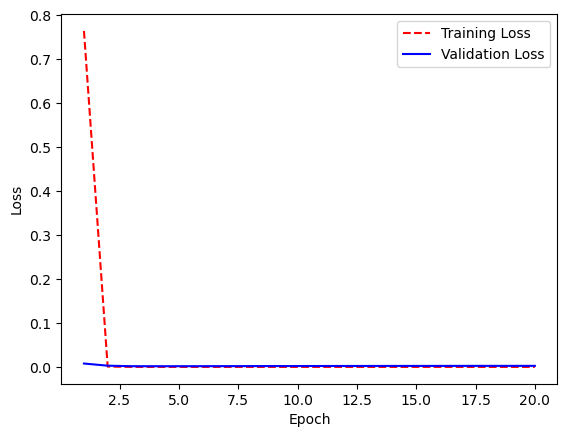

In [18]:
# Get training and test loss histories
training_loss = ans.history['loss']
validation_loss = ans.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

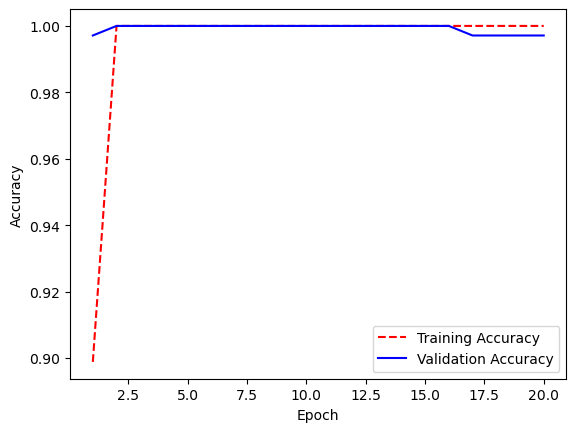

In [20]:
# Get training and test loss histories
training_loss = ans.history['accuracy']
validation_loss = ans.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [17]:
predict = np.argmax(model.predict(testing_dataset), axis = 1)
count = 0
for i in range(0,predict.shape[0]):
    if (predict[i] == np.argmax(testing_label[i])):
        count +=1
print ('Accuracy on Test ',100 * count/predict.shape[0],'%')

32/32 [==============================] - 100s 3s/step
Accuracy on Test  100.0 %
